In [89]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.emulator import Emulator
import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import xgboost as xg
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, STATUS_FAIL

In [2]:
R='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
files = glob.glob(os.path.join(base,f'*_R_{R}/*.h5'))
batchsize = int(2**16)
batchsize_test = int(2**19)

load = True
load_model = False

In [3]:
opac = ReadOpacChubb(files)
emulator = Emulator(opac)
emulator_test = Emulator(opac)

In [4]:
emulator.setup_sampling_grid(batchsize=batchsize, filename=f'data/input_{batchsize}', load=load)
emulator.setup_mix(filename=f'data/mix_R_{R}_{batchsize}', load=load, test_size=0.01);
emulator_test.setup_sampling_grid(batchsize=batchsize_test, filename=f'data/input_{batchsize_test}', load=load)
emulator_test.setup_mix(filename=f'data/mix_R_{R}_{batchsize_test}', load=load, test_size=0.99);

In [5]:
xgb_reg_params = {
    'n_estimators': hp.quniform('n_estimators', 20, 70, 1),
    'max_depth': hp.quniform('max_depth', 5, 10, 1),
    'tree_method':      'gpu_hist',
    'early_stopping_rounds': 10,
}
# Note: We may not be able to use early stopping, since results can be vary bad and that would break the fmin function

xgb_fit_params = {
    'verbose': False,
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [6]:
class HPOpt(object):
    """
    Following this example:
    https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e
    """

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        # para['reg_params']['max_depth'] = int(para['reg_params']['max_depth'])
        # para['reg_params']['min_child_weight'] = int(para['reg_params']['min_child_weight'])
        para['reg_params']['n_estimators'] = int(para['reg_params']['n_estimators'])        
        
        reg = xg.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        x_train = emulator.input_scaling(self.x_train)
        x_test = emulator.input_scaling(self.x_test)

        y_train = np.log10(self.y_train)
        y_test = np.log10(self.y_test)
        
        reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], **para['fit_params'])
        t0=time.time()
        pred = reg.predict(x_test)
        t1=time.time()
        loss = para['loss_func'](y_test, pred)*(t1-t0)
        return {'loss': loss, 'status': STATUS_OK}

In [7]:
trials = Trials()

In [52]:
obj = HPOpt(emulator.X_train, emulator_test.X_test, emulator.y_train, emulator_test.y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=1000)
# xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=xgb_opt[1], algo=tpe.suggest, max_evals=1000)

 99%|█████████▉| 993/1000 [1:15:59<03:38, 31.23s/trial, best loss: 3.232887127104485]


KeyboardInterrupt: 

In [53]:
trials.best_trial

{'state': 2,
 'tid': 688,
 'spec': None,
 'result': {'loss': 3.232887127104485, 'status': 'ok'},
 'misc': {'tid': 688,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'learning_rate': [688],
   'max_depth': [688],
   'min_child_weight': [688],
   'n_estimators': [688]},
  'vals': {'learning_rate': [0.04142970026023755],
   'max_depth': [3.0],
   'min_child_weight': [6.0],
   'n_estimators': [145.0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2023, 2, 20, 12, 45, 19, 664000),
 'refresh_time': datetime.datetime(2023, 2, 20, 12, 45, 34, 998000)}

(array([720., 206.,  29.,   9.,   9.,   3.,   1.,   0.,   2.,   0.,   3.,
          1.,   4.,   1.,   3.,   0.,   0.,   0.,   0.,   2.]),
 array([3.23288713, 3.37547273, 3.51805833, 3.66064393, 3.80322954,
        3.94581514, 4.08840074, 4.23098635, 4.37357195, 4.51615755,
        4.65874315, 4.80132876, 4.94391436, 5.08649996, 5.22908556,
        5.37167117, 5.51425677, 5.65684237, 5.79942797, 5.94201358,
        6.08459918]),
 <BarContainer object of 20 artists>)

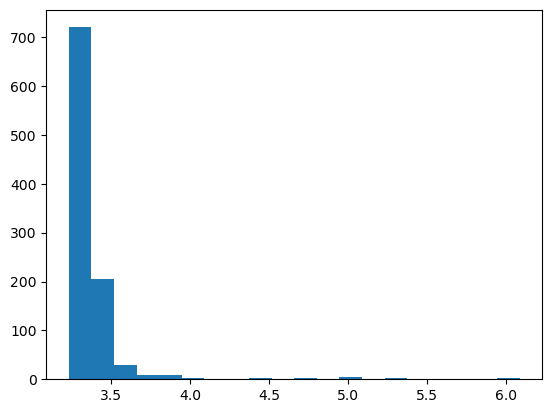

In [54]:
losses = np.asarray(trials.losses(), dtype=np.float_)
hist_cts, hist_edges = np.histogram(losses[np.isfinite(losses)])
plt.hist(losses[np.isfinite(losses)], bins=20)

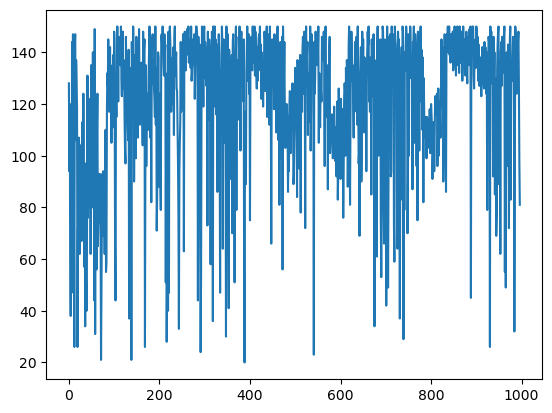

(array([ 14.,  15.,  19.,  27.,  43.,  63.,  89., 132., 224., 371.]),
 array([ 20.,  33.,  46.,  59.,  72.,  85.,  98., 111., 124., 137., 150.]),
 <BarContainer object of 10 artists>)

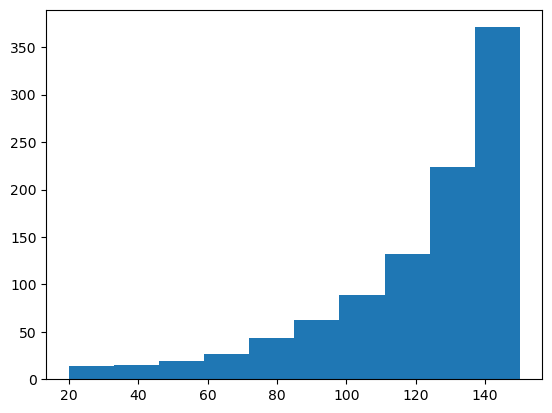

In [70]:
plt.plot(trials.vals['n_estimators'])
plt.show()
plt.hist(trials.vals['n_estimators'])

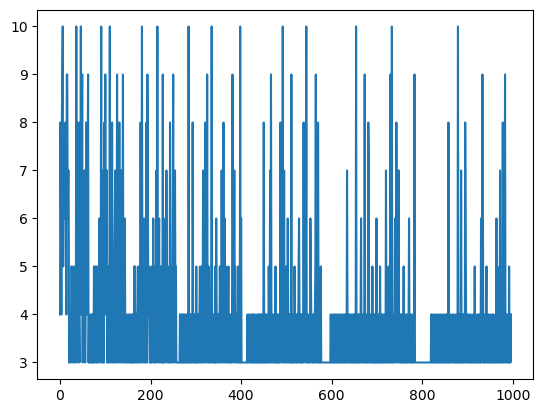

(array([541., 269.,  65.,   0.,  34.,  28.,   0.,  24.,  21.,  15.]),
 array([ 3. ,  3.7,  4.4,  5.1,  5.8,  6.5,  7.2,  7.9,  8.6,  9.3, 10. ]),
 <BarContainer object of 10 artists>)

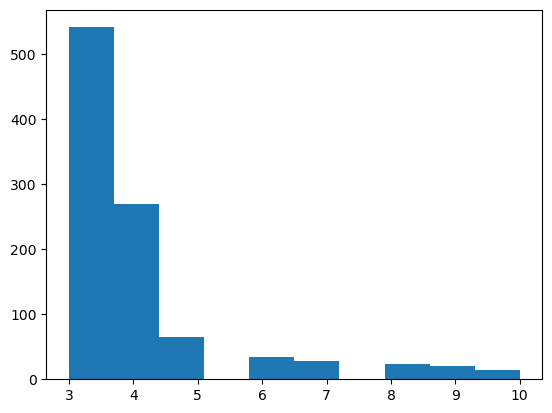

In [61]:
plt.plot(trials.vals['max_depth'])
plt.show()
plt.hist(trials.vals['max_depth'])

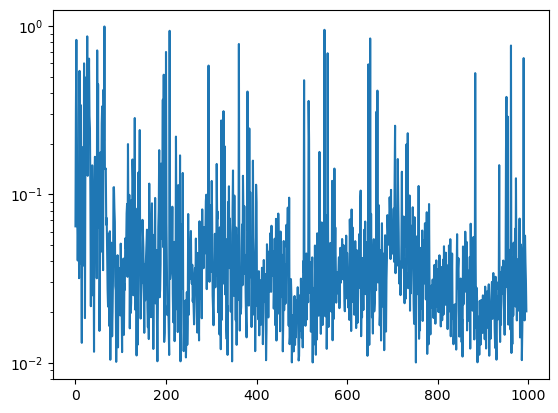

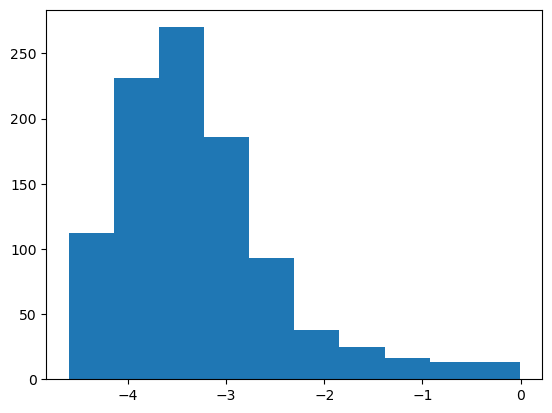

(array([112., 231., 270., 186.,  93.,  38.,  25.,  16.,  13.,  13.]), array([-4.60363086, -4.14401295, -3.68439505, -3.22477714, -2.76515924,
       -2.30554133, -1.84592343, -1.38630553, -0.92668762, -0.46706972,
       -0.00745181]), <BarContainer object of 10 artists>)


In [66]:
plt.plot(trials.vals['learning_rate'])
plt.yscale('log')
plt.show()
hist =plt.hist(np.log(trials.vals['learning_rate']))
plt.show()
print(hist)

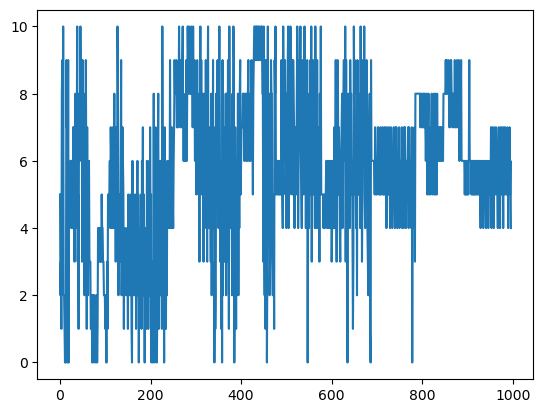

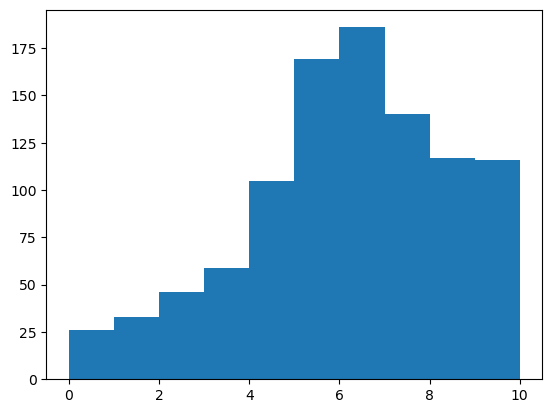

(array([ 26.,  33.,  46.,  59., 105., 169., 186., 140., 117., 116.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), <BarContainer object of 10 artists>)


In [88]:
plt.plot(trials.vals['min_child_weight'])
plt.show()
hist =plt.hist(trials.vals['min_child_weight'])
plt.show()
print(hist)

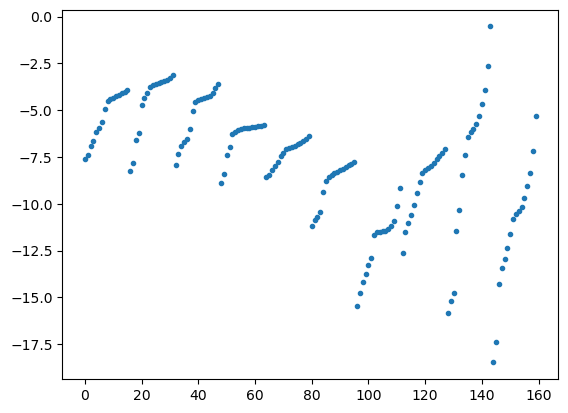

In [85]:
plt.plot(np.log(emulator.y_train[-1]), '.')
# plt.yscale('log')

In [71]:
# import pickle

In [73]:
# with open('data/hyperopt.pickle', 'wb') as f:
#     pickle.dump(trials, f)